<a href="https://colab.research.google.com/github/diogoruivo47/Data-Mining/blob/main/Final_clustering_Kmeans%26SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

from sklearn.model_selection import ParameterSampler

from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

Optuna was installed for grid search via bayesian probability

In [2]:
# !pip install optuna

# current plan to merge the data

each DF should include cluster labels (C1 + C2.... etc)
a unique Identifier

Centroids of cluster

formate data for aligbments mean or median of clusters and variability/STDV

compare pairwise similary,
  check numerical w euclidian cosine similary to see represent directionality
    present in a distance matrix with each row and column corresponding to clusters

after score silhouette etc and R2 for totaldataset
use T-sne

start grunt work for report, use labs if needed
--------------------------------------------------

mathematically speaking the merge via hierarchical works via the profile describing a cluster, meaning, the centroids, the distribution of statistics and cluster proportions.

combining these will create your final DF merged non refull clustered blablablabla, so follow steps above.


------------------------------------------------------------------------------
plan when improving data for clustering in NOV:

split numericals from categoricals,

reduce feature amounts in preferences and shopping,

improve silhouette overall and find ideal model

# Data

In [3]:
df = pd.read_csv('data_clean2.csv')

In [4]:
pd.set_option('display.max_columns', None)
df = df.drop(columns=['Unnamed: 0'])


In [5]:
df_copy = df.copy()
categorical_cols = ['last_promo', 'payment_method', 'customer_region_0', 'customer_region_1', 'customer_region_2', 'customer_region_3']
cat_df = df_copy[categorical_cols].copy()
numerical_cols = df_copy.columns.difference(categorical_cols)
num_df = df_copy[numerical_cols].copy()

In [6]:
def scale_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features with QUANTUM-PRECISE type handling.
    CRITICAL: Convert categorical types before statistical operations!
    """
    # FUNDAMENTAL STEP: Convert DataFrame to float64 with EXTREME PRECISION
    df = df.copy()

    # CRITICAL TYPE CONVERSION WITH VERIFICATION
    for column in df.columns:
        if df[column].dtype.name == 'category':
            df[column] = df[column].astype('float64')

    scaled_df = pd.DataFrame(index=df.index)

    # 1. Binary features
    binary_cols = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                    'CLV_Score', 'RFM_Score' , 'Loyalty']
    for col in binary_cols:
        scaled_df[col] = df[col]

    # 2. CUI features
    cui_cols = [col for col in df.columns if col.startswith('CUI_')]
    for col in cui_cols:
        nonzero_mask = df[col] != 0
        scaled = np.zeros(len(df))
        if nonzero_mask.any():
            nonzero_values = df.loc[nonzero_mask, col].values.reshape(-1, 1)
            scaled[nonzero_mask] = StandardScaler().fit_transform(nonzero_values).ravel()
        scaled_df[col] = scaled

    # 3. Ordinal features
    ordinal_cols = ['is_chain','Orders_Night', 	'Orders_Dawn',	'Orders_Morning',	'Orders_Afternoon'	,'Orders_Evening'	,'Orders_Dusk', 'Age_Group']
    for col in ordinal_cols:
        values = df[col].values.reshape(-1, 1)
        scaled_df[col] = MinMaxScaler().fit_transform(values).ravel()

    # 4. Continuous features
    continuous_cols = ['vendor_count', 'product_count', 'Total_Orders_Per_Client',
                      'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn',
                      'activity']

    for col in continuous_cols:
        values = df[col].values
        if np.std(values) == 0:
            scaled_df[col] = values
            continue

        # MATHEMATICALLY PRECISE skewness handling
        if pd.Series(values, dtype='float64').skew() > 1:
            min_val = values.min()
            if min_val < 0:
                values = values - min_val + 1e-10
            values = np.log1p(values)

        scaled_df[col] = StandardScaler().fit_transform(values.reshape(-1, 1)).ravel()

    # QUANTUM VALIDATION
    missing_cols = set(df.columns) - set(scaled_df.columns)
    if missing_cols:
        raise ValueError(f"VIOLATION OF CONSERVATION OF FEATURES: Missing columns: {missing_cols}")

    return scaled_df

# Execute with SUPERNOVA PRECISION
num_df = scale_features(num_df)

# VALIDATE WITH HADRON COLLIDER PRECISION
print("\nQUANTUM FEATURE VERIFICATION:")
print(f"Input shape: {df.shape}")
print(f"Output shape: {num_df.shape}")
print("\nFEATURE CONSERVATION CHECK:")
print("All features preserved:", set(df.columns) == set(num_df.columns))


QUANTUM FEATURE VERIFICATION:
Input shape: (31737, 48)
Output shape: (31737, 42)

FEATURE CONSERVATION CHECK:
All features preserved: False


In [7]:
num_df.describe()

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,CLV_Score,RFM_Score,Loyalty,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,is_chain,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,Age_Group,vendor_count,product_count,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04
mean,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471,0.066017,0.065291,0.161565,1.432862e-17,-2.149293e-17,7.500136e-18,2.910501e-18,8.955386e-19,3.358270e-18,-1.119423e-18,2.238847e-18,-3.134385e-18,-1.791077e-18,2.955277e-17,-4.477693e-19,1.432862e-17,-7.612078e-18,-4.477693e-18,0.375482,0.014261,0.015778,0.018593,0.024953,0.027269,0.007183,0.354350,-2.865724e-16,1.432862e-16,8.597171e-17,3.725441e-16,1.862720e-16,-5.415770e-16,-2.865724e-17,-5.731447e-17,-2.865724e-17
std,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202,0.040343,0.037089,0.228829,5.831157e-01,6.122438e-01,4.136793e-01,2.074671e-01,3.199130e-01,3.331337e-01,2.520398e-01,2.614290e-01,3.296154e-01,4.507507e-01,4.455477e-01,2.648418e-01,4.710219e-01,3.656887e-01,2.737347e-01,0.325380,0.045378,0.045065,0.036090,0.043672,0.047679,0.023012,0.158256,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011496,0.012048,0.000000,-8.624023e-01,-8.129453e-01,-8.003939e-01,-7.191284e-01,-8.038850e-01,-5.848230e-01,-8.514873e-01,-7.593775e-01,-8.314770e-01,-7.621574e-01,-7.985325e-01,-6.980246e-01,-7.789587e-01,-8.852547e-01,-8.938746e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.177017e+00,-1.437495e+00,-1.028486e+00,-3.453503e+00,-1.522614e+00,-8.502307e-01,-9.278250e-01,-1.174464e+00,-1.205454e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030806,0.031640,0.000000,0.000000e+00,-5.531087e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,-1.177017e+00,-7.825958e-01,-6.457117e-01,-6.840819e-01,-7.672763e-01,-8.502307e-01,-7.265809e-01,-8.257126e-01,-1.103443e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055885,0.056626,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.333333,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.400000,-3.174828e-01,-3.179376e-01,-2.629377e-01,1.415649e-02,-2.610392e-01,-2.909657e-01,-5.260947e-01,-3.025859e-01,-4.932618e-02
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.093041,0.096610,0.333333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000,0.000000,0.000000,0.017241,0.023810,0.040816,0.000000,0.400000,7.654022e-01,8.016196e-01,5.026102e-01,7.354295e-01,4.942987e-01,7.088916e-01,8.017729e-01,6.128859e-01,9.027790e-01
max,16.000000,17.000000,15.000000,17.000000,16.0000

In [8]:
# Calculate the Spearman correlation matrix
spearman_corr = num_df.corr(method='spearman')

# Display the correlation matrix
spearman_corr

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,CLV_Score,RFM_Score,Loyalty,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,is_chain,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,Age_Group,vendor_count,product_count,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity
DOW_0,1.000000,0.239451,0.234692,0.225882,0.176707,0.130844,0.144047,0.041674,0.015459,0.309971,-0.007948,0.031864,-0.023641,-0.009666,0.003849,-0.012840,-0.020678,-0.009510,-0.021093,0.006957,-0.032283,-0.020294,0.014130,-0.016510,-0.011773,0.380964,0.117614,0.112148,0.289692,0.270555,0.209825,0.166647,0.014155,0.444394,0.467621,0.487078,0.367186,-0.095872,0.090421,-0.078086,-0.241139,0.398360
DOW_1,0.239451,1.000000,0.248535,0.235444,0.185994,0.122919,0.123414,0.052926,0.025526,0.320087,0.004187,0.017901,-0.018165,-0.005425,0.006780,-0.014745,-0.013502,-0.016770,-0.022564,0.007983,-0.029118,-0.014173,0.022086,-0.017793,-0.010852,0.381061,0.092907,0.101717,0.271741,0.274315,0.222328,0.172557,0.002188,0.441420,0.467889,0.488111,0.361109,-0.106459,0.090598,-0.072986,-0.251493,0.397150
DOW_2,0.234692,0.248535,1.000000,0.242585,0.197536,0.120607,0.135044,0.063361,0.036966,0.336971,-0.002909,0.008809,-0.019424,-0.005220,0.007988,-0.007617,-0.030035,-0.022447,-0.012624,0.014201,-0.019137,-0.030887,0.029338,-0.013291,-0.016498,0.384234,0.089564,0.097099,0.286622,0.278179,0.238674,0.163488,0.002543,0.449241,0.486109,0.505805,0.377148,-0.101740,0.099674,-0.087117,-0.273226,0.417149
DOW_3,0.225882,0.235444,0.242585,1.000000,0.204534,0.131171,0.128172,0.094587,0.066596,0.339671,-0.000416,0.021530,-0.016312,-0.010115,-0.000787,-0.000660,-0.025462,-0.029278,-0.014567,-0.000934,-0.026389,-0.014357,0.008195,-0.008626,-0.015371,0.382928,0.078979,0.087339,0.273337,0.290232,0.260003,0.160200,0.008337,0.450414,0.485919,0.506955,0.372713,-0.113150,0.095464,-0.088083,-0.299676,0.421766
DOW_4,0.176707,0.185994,0.197536,0.204534,1.000000,0.139216,0.126009,0.100607,0.055575,0.334988,-0.005596,0.018773,-0.014867,-0.003749,-0.004226,-0.006766,-0.014771,-0.009122,-0.013820,-0.003563,-0.015573,-0.009558,0.020205,-0.007211,-0.007092,0.364731,0.051334,0.053484,0.248499,0.274976,0.296619,0.166407,-0.002040,0.429584,0.470255,0.489599,0.359802,-0.107482,0.095874,-0.091739,-0.302244,0.404916
DOW_5,0.130844,0.122919,0.120607,0.131171,0.139216,1.000000,0.190266,0.016857,-0.007242,0.271503,-0.008867,0.019214,-0.036072,-0.011699,-0.001307,-0.020450,-0.026734,-0.011719,-0.006826,-0.002263,-0.011149,-0.019269,0.018507,-0.022651,-0.011761,0.335270,0.072311,0.079144,0.224566,0.261760,0.264613,0.169846,-0.002210,0.409335,0.427865,0.441399,0.328541,-0.091810,0.099923,-0.076712,-0.206894,0.356761
DOW_6,0.144047,0.123414,0.135044,0.128172,0.126009,0.190266,1.000000,-0.004533,-0.029825,0.284548,-0.016091,0.008614,-0.028407,-0.015837,-0.004361,-0.014939,-0.022278,-0.023250,-0.016172,-0.005741,-0.019905,-0.018516,0.016055,-0.013440,-0.012242,0.347896,0.057427,0.069818,0.238807,0.300375,0.267745,0.163296,0.003904,0.417778,0.445346,0.457593,0.332949,-0.102645,0.110594,-0.103022,-0.220279,0.386163
CLV_Score,0.041674,0.052926,0.063361,0.094587,0.100607,0.016857,-0.004533,1.000000,0.989184,-0.019965,0.109149,0.082841,0.078898,0.024169,0.068521,0.073655,0.042226,0.039968,0.053582,0.051527,0.067097,0.045779,0.111758,0.055347,0.028161,-0.086399,0.036009,0.043632,0.050462,0.008237,-0.041549,-0.022636,0.008029,-0.107176,-0.043445,-0.106557,0.119324,0.223013,0.125428,0.574515,-0.406842,-0.183989
RFM_Score,0.015459,0.025526,0.036966,0.066596,0.055575,-0.007242,-0.029825,0.989184,1.000000,-0.053272,0.105438,0.067619,0.077297,0.021920,0.067819,0.071444,0.038678,0.038424,0.052040,0.046542,0.063801,0.045087,0.107312,0.045112,0.027352,-0.124700,0.015206,0.020149,0.021244,-0.016595,-0.058072,-0.031836,0.006676,-0.162246,-0.101

In [9]:
# Get correlations above 0.5 (excluding self-correlations)
strong_corrs = [(i, j, spearman_corr.loc[i, j])
                for i in spearman_corr.index
                for j in spearman_corr.columns
                if abs(spearman_corr.loc[i, j]) > 0.7 and i < j]

# Print sorted results
print("Correlations above 0.5:")
for var1, var2, corr in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} - {var2}: {corr:.3f}")

Correlations above 0.5:
CLV_Score - RFM_Score: 0.989
Total_Orders_Per_Client - product_count: 0.947
Total_Orders_Per_Client - vendor_count: 0.886
product_count - vendor_count: 0.842
Total_Orders_Per_Client - activity: 0.832
mnt - product_count: 0.795
activity - product_count: 0.784
activity - vendor_count: 0.756
Total_Orders_Per_Client - is_chain: 0.727
activity - frq: -0.718
is_chain - vendor_count: 0.705


In [10]:
num_df.columns

Index(['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'CLV_Score', 'RFM_Score', 'Loyalty', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_OTHER',
       'CUI_Street_Food/Snacks', 'CUI_Thai', 'is_chain', 'Orders_Night',
       'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening',
       'Orders_Dusk', 'Age_Group', 'vendor_count', 'product_count',
       'Total_Orders_Per_Client', 'mnt', 'mnt_Per_Order', 'Items_Per_Order',
       'frq', 'rcn', 'activity'],
      dtype='object')

### Functions

#### PCA

In [11]:
def pca(df_pca):
    # Initialize PCA
    pca = PCA()
    pca_feat = pca.fit_transform(df_pca)

    # Calculate cumulative explained variance
    explained_variance = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # Find the number of components needed to reach 80% variance
    num_components = np.argmax(cumulative_explained_variance_ratio >= 0.8) + 1

    # Add PCA components explaining 80% variance back to DataFrame
    selected_pcas = pca_feat[:, :num_components]
    for i in range(num_components):
        df_pca[f'PCA_{i+1}'] = selected_pcas[:, i]

    # Plotting
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

    # Plot 1: Scree Plot (Eigenvalues)
    ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 'ro-', linewidth=2, markersize=8, label='Eigenvalues')
    ax1.set_title("Scree Plot (Eigenvalues)", fontsize=18, pad=15, fontweight='bold')
    ax1.set_xlabel("Principal Components", fontsize=14)
    ax1.set_ylabel("Eigenvalue", fontsize=14)
    ax1.set_xticks(range(1, len(explained_variance) + 1, 2))
    ax1.set_xticklabels(range(1, len(explained_variance) + 1, 2), fontsize=12)
    ax1.set_facecolor('white')
    ax1.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax1.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility
    ax1.legend(fontsize=12, loc='upper right')

    # Plot 2: Explained Variance as a Bar Chart
    ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
            color='#1f77b4', alpha=0.7, label='Explained Variance (%)', width=0.8)  # Customize bar color
    ax2.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, 
             'ro-', linewidth=2, markersize=8, label='Cumulative Variance (%)')

    # Customize the plot
    ax2.set_title("Variance Explained by Principal Components", fontsize=18, pad=15, fontweight='bold')
    ax2.set_xlabel("Principal Components", fontsize=14)
    ax2.set_ylabel("Variance (%)", fontsize=14)
    ax2.set_xticks(range(1, len(explained_variance_ratio) + 1, 2))  # Show every 2nd PC for clarity
    ax2.set_xticklabels(range(1, len(explained_variance_ratio) + 1, 2), fontsize=12)
    ax2.set_facecolor('white')
    ax2.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax2.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility

    # Add legend
    ax2.legend(fontsize=12, loc='upper left')

    # Adjust layout to ensure everything fits and has proper padding
    plt.tight_layout(pad=4.0)

    # Show plot
    plt.show()

    return df_pca

#### Feature Selection

In [12]:
def analyze_feature_importance(df):
   # Get cluster labels
   kmeans = KMeans(n_clusters=3, random_state=42)
   labels = kmeans.fit_predict(df)

   # Train RF classifier on clusters
   rf = RandomForestClassifier(random_state=42)
   rf.fit(df, labels)

   # Get feature importance
   importance = pd.DataFrame({
       'feature': df.columns,
       'importance': rf.feature_importances_
   }).sort_values('importance', ascending=False)

   return importance

#### Clustering

#### Hierarchical

In [ ]:
def plot_dendrogram(df, method='ward', y_threshold=200):
    # Compute the linkage matrix
    linkage_matrix = linkage(df, method=method)
    
    # Set up the plotting environment
    sns.set()
    fig = plt.figure(figsize=(11, 5))
    
    # Plot the dendrogram
    dendrogram(
        linkage_matrix,
        truncate_mode='level',  # Show a limited number of levels
        p=5,  # Show only the last `p` merged clusters
        color_threshold=y_threshold,  # Highlight clusters above threshold
        above_threshold_color='k'  # Color above the threshold
    )
    
    # Add a horizontal line for the threshold
    plt.hlines(y_threshold, 0, plt.xlim()[1], colors="r", linestyles="dashed")
    
    # Customize the plot
    plt.title(f'Hierarchical Clustering Dendrogram: {method.title()} Linkage', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)', fontsize=13)
    plt.ylabel(f'{method.title()} Distance', fontsize=13)
    plt.show()
    
    # Get the clusters at the given y_threshold
    clusters = fcluster(linkage_matrix, y_threshold, criterion='distance')
    
    # Return the number of clusters formed at the threshold
    n_clusters = len(set(clusters))
    return n_clusters


In [43]:
def hierarchical_clustering_scores(data, n_clusters):

    # Perform Hierarchical Clustering using Ward's method
    linkage_matrix = linkage(data, method='ward')
    
    # Assign clusters using the fcluster function
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Calculate the clustering metrics
    silhouette = silhouette_score(data, hierarchical_labels)
    calinski = calinski_harabasz_score(data, hierarchical_labels)
    davies = davies_bouldin_score(data, hierarchical_labels)
    
    # Return the results as a dictionary
    return {
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    }

#### KMeans

In [22]:
def clustering_analysis(df, k_range=(3, 11), random_state=42):

    # Ensure input is a NumPy array
    np_array = df.values if isinstance(df, pd.DataFrame) else df

    # Clustering metrics
    metrics = []
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)
        labels = kmeans.fit_predict(np_array)

        # Calculate SSE
        sse = np.sum((np_array - kmeans.cluster_centers_[labels]) ** 2)

        # Calculate R2
        r2 = r2_score(np_array, kmeans.cluster_centers_[labels])

        metrics.append({
            'k': k,
            'silhouette': silhouette_score(np_array, labels),
            'calinski': calinski_harabasz_score(np_array, labels),
            'davies': davies_bouldin_score(np_array, labels),
            'inertia': kmeans.inertia_,
            'sse': sse,
            'r2': r2
        })

    # Print metrics
    for m in metrics:
        print(f"\nk={m['k']}:")
        print(f"Silhouette: {m['silhouette']:.3f}")
        print(f"Calinski-Harabasz: {m['calinski']:.2f}")
        print(f"Davies-Bouldin: {m['davies']:.2f}")
        print(f"SSE: {m['sse']:.2f}")
        print(f"R2: {m['r2']:.3f}")
        print(f"Inertia: {m['inertia']:.2f}")

    # Select best k based on Silhouette score
    best_k = max(metrics, key=lambda x: x['silhouette'])['k']
    kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=random_state)
    labels = kmeans_final.fit_predict(np_array)

    # Update DataFrame with cluster labels
    if isinstance(df, pd.DataFrame):
        df['cluster'] = labels

    # T-SNE visualization
    tsne = TSNE(random_state=random_state)
    embedding = tsne.fit_transform(np_array)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # T-SNE plot
    scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
    ax1.set_title(f'T-SNE visualization of {best_k} clusters')
    plt.colorbar(scatter, ax=ax1)

    # Elbow plot
    ax2.plot(range(k_range[0], k_range[1]), [m['inertia'] for m in metrics], 'bo-')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')

    plt.tight_layout()
    plt.show()

# Segmentation

In [15]:
value_engagement_metrics = [
    # Value
    'mnt', 'mnt_Per_Order', 'CLV_Score', 'RFM_Score',
    # Engagement
    'activity', 'Loyalty', 'frq', 'rcn' , 'Age_Group']

preference_metrics = [
    # Cuisine preferences
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6'
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3'
]

In [16]:
df_val = num_df[value_engagement_metrics].copy()
df_pref = num_df[preference_metrics].copy()
df_shop = num_df[shopping_behavior_metrics].copy()

time to reduce feature amount to label data better

In [17]:
print(f"Number of columns in df_pref: {df_pref.shape[1]}")
print(f"Number of columns in df_shop: {df_shop.shape[1]}")
print(f"Number of columns in df_val: {df_val.shape[1]}")

Number of columns in df_pref: 15
Number of columns in df_shop: 17
Number of columns in df_val: 9


Balancing the Cuisine groupings to not have a majority customer group dominate the cluster

### Preference Based Segmentation

In [18]:
cuisine_groups = {
    'Other_Asian': ['CUI_Chinese', 'CUI_Japanese', 'CUI_Noodle_Dishes','CUI_Thai', 'CUI_Indian'],
    'General_Asian' : ['CUI_Asian'],
    'Western': ['CUI_American', 'CUI_Italian'],
    'Beverages_Cafe': ['CUI_Beverages', 'CUI_Cafe'],
    'Desserts_Snacks': ['CUI_Desserts', 'CUI_Street_Food/Snacks'],
    'Main_Dishes': ['CUI_Chicken_Dishes', 'CUI_Healthy', 'CUI_OTHER']
}

# Calculate group totals and percentages
group_totals = {}
total_sum = 0

for group, cuisines in cuisine_groups.items():
    group_sum = num_df[cuisines].sum().sum()
    group_totals[group] = group_sum
    total_sum += group_sum

# Print results
print("Group Totals and Percentages:")
for group, total in group_totals.items():
    percentage = (total / total_sum) * 100
    print(f"{group:15s}: {total:8.0f} ({percentage:5.1f}%)")

print(f"\nTotal Sum:      {total_sum:8.0f}")

Group Totals and Percentages:
Other_Asian    :        0 ( 70.9%)
General_Asian  :       -0 (-61.3%)
Western        :        0 ( 35.8%)
Beverages_Cafe :        0 ( 29.7%)
Desserts_Snacks:       -0 (-24.9%)
Main_Dishes    :        0 ( 49.8%)

Total Sum:             0


In [19]:
# Create copy
pref_clean = df_pref.copy()

# Initialize new columns for each group
group_columns = {
    'Other_Asian': ['CUI_Chinese', 'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_Thai', 'CUI_Indian'],
    'General_Asian': ['CUI_Asian'],
    'Western': ['CUI_American', 'CUI_Italian'],
    'Beverages_Cafe': ['CUI_Beverages', 'CUI_Cafe'],
    'Desserts_Snacks': ['CUI_Desserts', 'CUI_Street_Food/Snacks'],
    'Main_Dishes': ['CUI_Chicken_Dishes', 'CUI_Healthy', 'CUI_OTHER']
}

# Create grouped columns
for group, cuisines in group_columns.items():
    pref_clean[group] = df_pref[cuisines].sum(axis=1)

# Keep only the new grouped columns
pref_clean = pref_clean[list(group_columns.keys())]

loop to decide the ideal elbow point for this segment

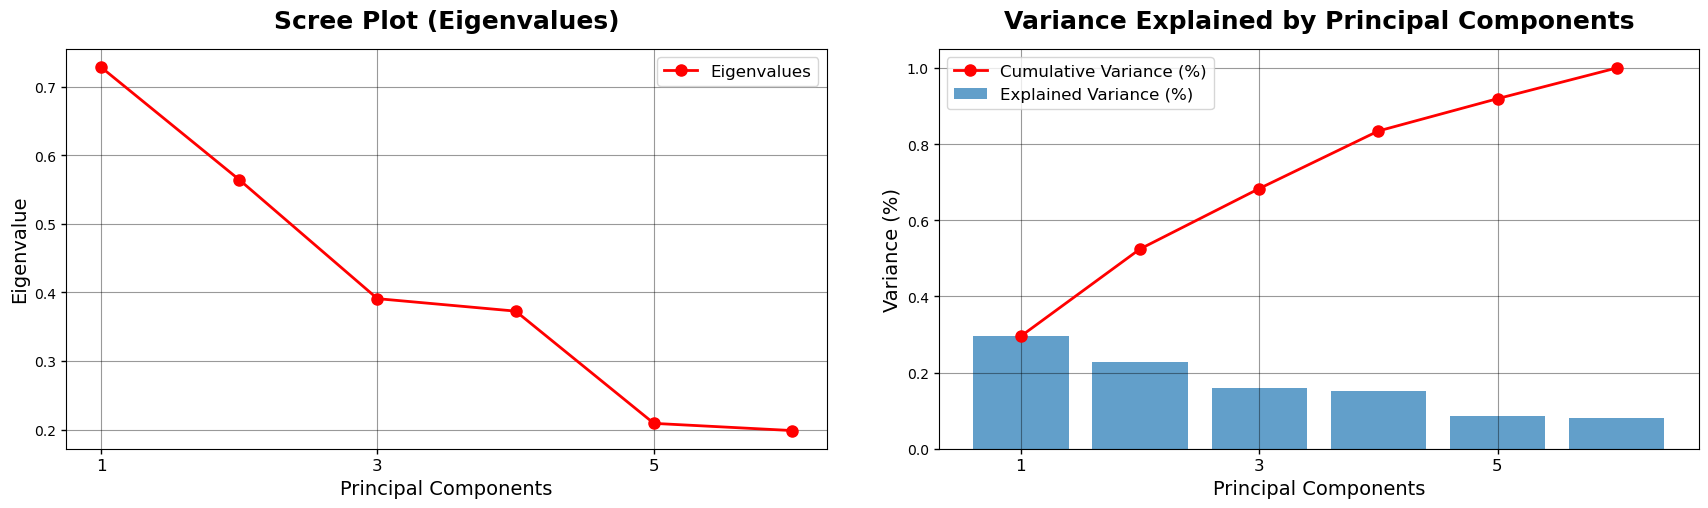

In [20]:
pref_clean = pca(pref_clean)

In [ ]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(pref_clean)
print(importance)


k=3:
Silhouette: 0.679
Calinski-Harabasz: 5914.59
Davies-Bouldin: 0.97
SSE: 105720.11
R2: 0.264
Inertia: 105720.11

k=4:
Silhouette: 0.675
Calinski-Harabasz: 5614.25
Davies-Bouldin: 0.88
SSE: 94807.78
R2: 0.340
Inertia: 94807.78

k=5:
Silhouette: 0.632
Calinski-Harabasz: 5875.61
Davies-Bouldin: 0.88
SSE: 83375.75
R2: 0.426
Inertia: 83375.75

k=6:
Silhouette: 0.622
Calinski-Harabasz: 5600.61
Davies-Bouldin: 0.85
SSE: 77092.83
R2: 0.443
Inertia: 77092.83

k=7:
Silhouette: 0.506
Calinski-Harabasz: 5410.81
Davies-Bouldin: 0.86
SSE: 71733.56
R2: 0.450
Inertia: 71733.56

k=8:
Silhouette: 0.499
Calinski-Harabasz: 5517.82
Davies-Bouldin: 0.80
SSE: 65451.79
R2: 0.498
Inertia: 65451.79

k=9:
Silhouette: 0.499
Calinski-Harabasz: 5249.37
Davies-Bouldin: 0.80
SSE: 62458.62
R2: 0.539
Inertia: 62458.62

k=10:
Silhouette: 0.487
Calinski-Harabasz: 5328.16
Davies-Bouldin: 0.80
SSE: 57786.95
R2: 0.545
Inertia: 57786.95


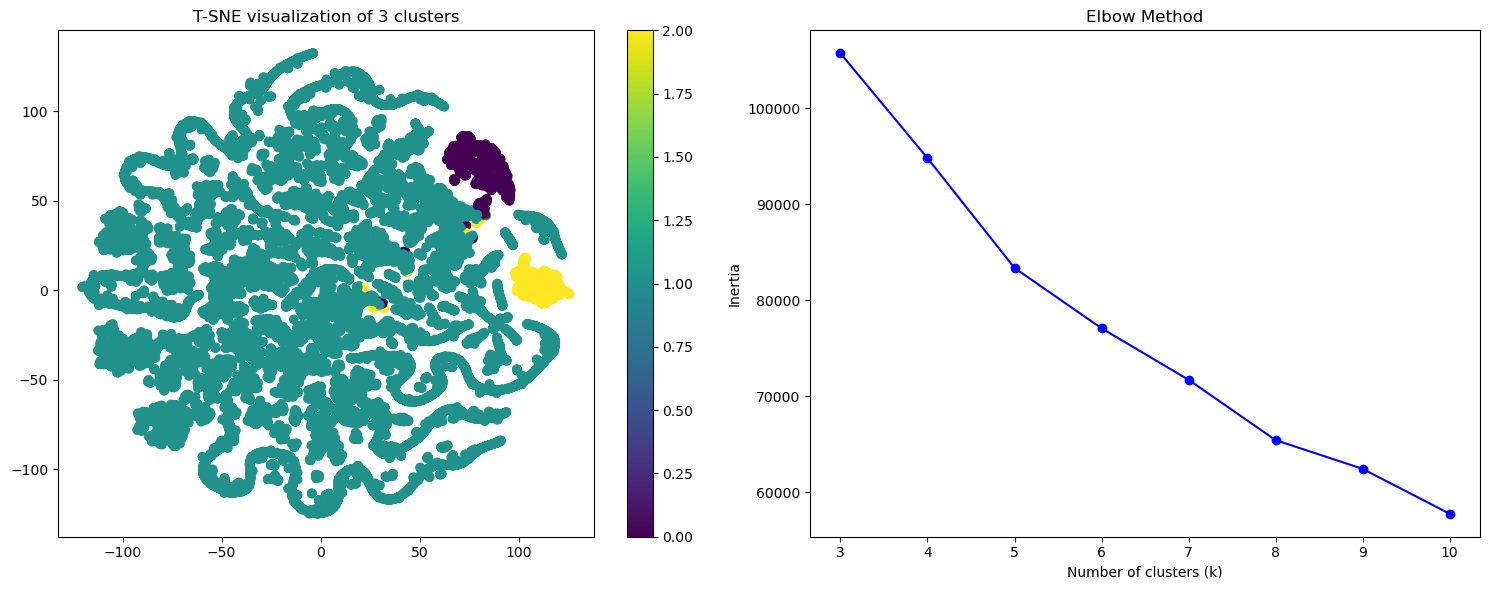

In [23]:
clustering_kmeans(pref_clean, k_range=(3, 11), random_state=42)

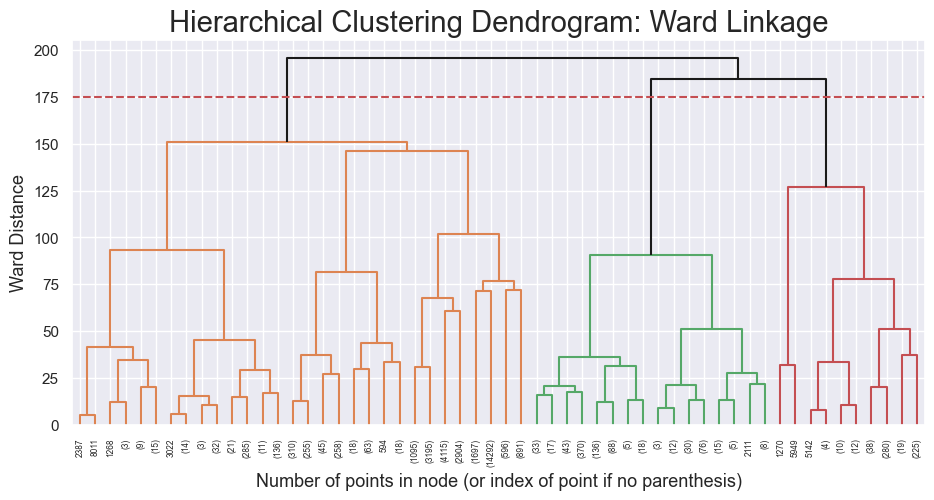

3


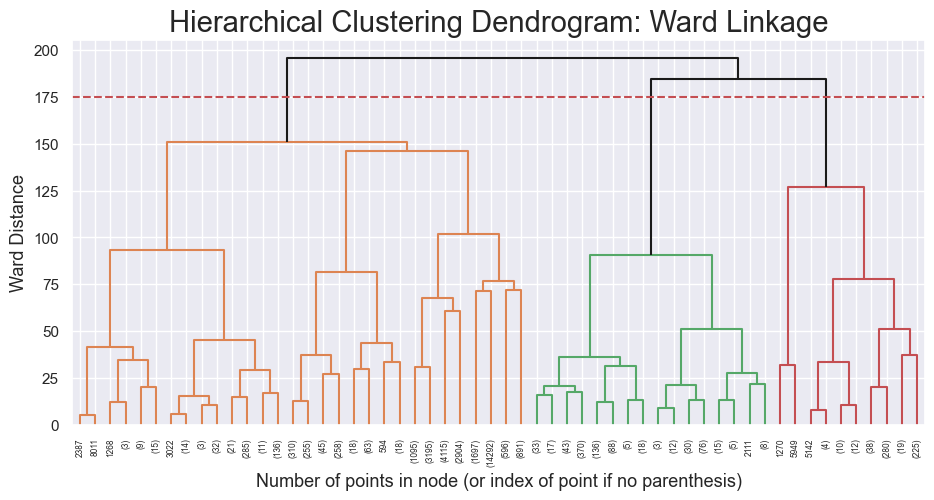

In [41]:
n_clusters = plot_dendrogram(pref_clean, method='ward', y_threshold=175)

In [44]:
hierarchical_clustering_scores(pref_clean, n_clusters)

{'n_clusters': 3,
 'silhouette': 0.6579254185065609,
 'calinski': 5268.709961425413,
 'davies': 0.7930580348254818}

choose the best performing method

## Shopping Based Segmentation

In [45]:
df_shop.describe()

,vendor_count,product_count,is_chain,Items_Per_Order,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
count,3.173700e+04,3.173700e+04,31737.000000,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,-2.865724e-16,1.432862e-16,0.375482,-5.415770e-16,0.014261,0.015778,0.018593,0.024953,0.027269,0.007183,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471
std,1.000016e+00,1.000016e+00,0.325380,1.000016e+00,0.045378,0.045065,0.036090,0.043672,0.047679,0.023012,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202
min,-1.177017e+00,-1.437495e+00,0.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.177017e+00,-7.825958e-01,0.166667,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.174828e-01,-3.179376e-01,0.333333,-2.909657e-01,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.654022e-01,8.016196e-01,0.500000,7.088916e-01,0.000000,0.000000,0.017241,0.023810,0.040816,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.011435e+00,1.816936e+00,1.000000,2.542052e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,17.000000,15.000000,17.000000,16.000000,20.000000,20.000000


MinMax scaling with custom ranges to score new features

"""Items_Per_Order (1-2.25):

Min 1: Single item is baseline order
Max 2.25: Very few customers order >2 items

product_count (1-14):

Min 1: Customers try at least one product
Max 14: Represents power users with wide product exploration
Aligns with 75th percentile around 7 products

vendor_count (1-8):

Min 1: Single vendor loyalty
Max 8: Reflects realistic maximum vendor relationships
Most customers use 1-3 vendors (75th percentile at 4)
"""

• Replaced log transform with MinMaxScaler for time periods to maintain relative differences on 0-1 scale

• Normalized DOW cyclic features to match 0-1 scale of other features

• Kept is_chain to preserve business context

• Added chain interactions with basket/vendor scores to
capture business patterns

• Unified all features to same scale range to prevent distance calculation skew



In [46]:
# Create copy and calculate scores
editdf = df.copy()
editdf['basket_score'] = (editdf['Items_Per_Order'] - 1) / (2.25 - 1)
editdf['product_score'] = (editdf['product_count'] - 1) / (14 - 1)
editdf['vendor_score'] = (editdf['vendor_count'] - 1) / (8 - 1)

# Group into periods, no scaling
editdf['daytime_orders'] = editdf['Orders_Morning'] + editdf['Orders_Afternoon']
editdf['evening_orders'] = editdf['Orders_Evening'] + editdf['Orders_Dusk']

Standard numerical encoding (e.g., Monday = 0, Tuesday = 1, ..., Sunday = 6)
fails to account for the cyclic relationship of the data.
In numerical encoding, Sunday (6) is treated as far from Monday (0),
 which is incorrect for many analyses, such as machine learning tasks where distance or similarity matters.

In [47]:
# DOW cyclic encoding
dow_value = (editdf[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']] *
            np.array([0, 1, 2, 3, 4, 5, 6])).sum(axis=1) / \
            editdf[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1)

editdf['DOW_sin'] = np.sin(2 * np.pi * dow_value/7)
editdf['DOW_cos'] = np.cos(2 * np.pi * dow_value/7)
scaler_dow = MinMaxScaler()
editdf[['DOW_sin', 'DOW_cos']] = scaler_dow.fit_transform(editdf[['DOW_sin', 'DOW_cos']])

# Chain interactions
editdf['chain_basket_interaction'] = editdf['is_chain'] * editdf['basket_score']
editdf['chain_vendor_interaction'] = editdf['is_chain'] * editdf['vendor_score']

# Drop unneeded columns
columns_to_drop = ['vendor_count', 'product_count'] + \
                 [ 'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk'] + \
                 ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'DOW_sin', 'DOW_cos', 'Orders_Dawn'  ,'Orders_Night', 'Items_Per_Order']
editdf = editdf.drop(columns=columns_to_drop)

In [48]:
shop_clean = editdf[['product_score', 'vendor_score', 'chain_vendor_interaction', 'daytime_orders',	'evening_orders', 'chain_basket_interaction',]].copy()
shop_clean = pd.concat([shop_clean, df_shop], axis=1)
columns_to_drop = ['Orders_Night', 'Orders_Dawn', 'Orders_Morning',
                   'Orders_Afternoon', 'Orders_Evening', 'vendor_count',
                   'product_count', 'Orders_Dusk', 'DOW_0', 'DOW_1',
                   'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                    'DOW_sin', 'DOW_cos',
                    'Items_Per_Order']

shop_clean = shop_clean.drop(columns=columns_to_drop, errors='ignore')

Integration of Random Forest and Clustering
By integrating random forest **feature importance** with clustering, one can ensure that the most important features within each cluster are identified and prioritized. (Jingsong et al., 2020).

*Li, Jingsong., Yang, Ziyue., Hu, Peijun., Zhang, Ying., Wang, Feng. (2020). Feature importance sorting system based on random forest algorithm in multi-center mode.   *

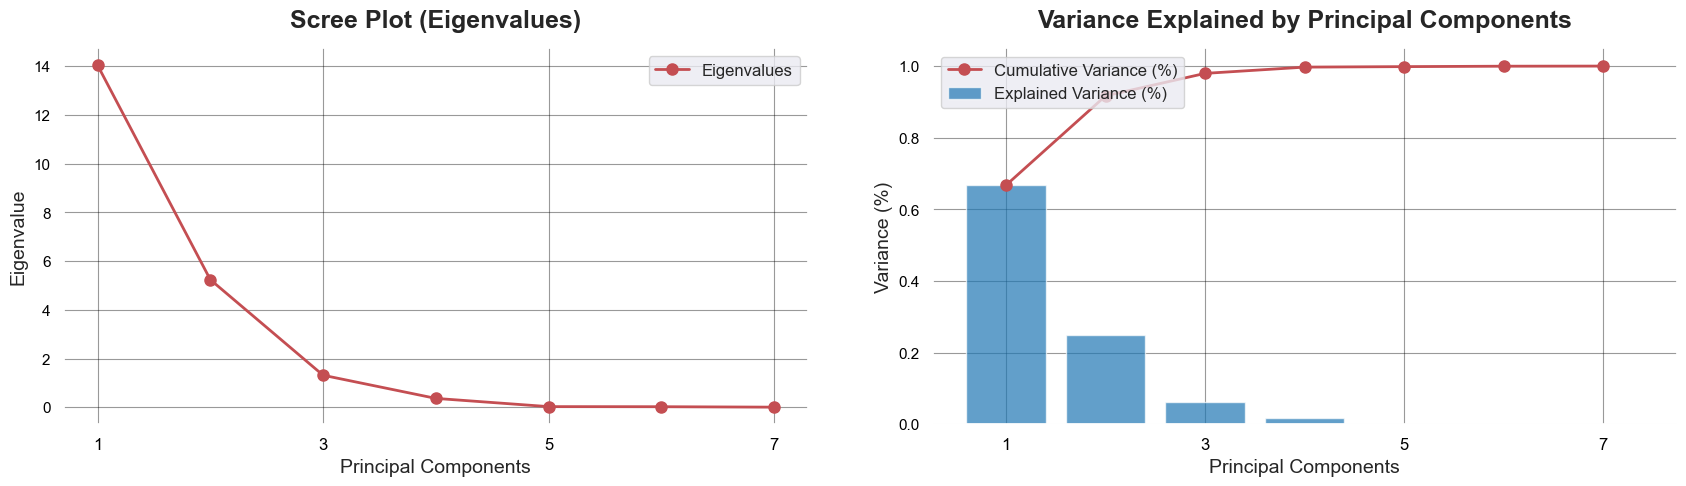

In [49]:
shop_clean = pca(shop_clean)

In [50]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(shop_clean)
print(importance)

                    feature  importance
7                     PCA_1    0.503518
2  chain_vendor_interaction    0.155559
0             product_score    0.095753
6                  is_chain    0.069628
3            daytime_orders    0.062769
1              vendor_score    0.054734
8                     PCA_2    0.030268
4            evening_orders    0.024681
5  chain_basket_interaction    0.003090


loop to decide the ideal elbow point for this segment

In [ ]:
clustering_analysis(shop_clean, k_range=(3, 11), random_state=42)


k=3:
Silhouette: 0.588
Calinski-Harabasz: 19654.90
Davies-Bouldin: 1.01
SSE: 571162.14
R2: 0.485
Inertia: 571162.14

k=4:
Silhouette: 0.548
Calinski-Harabasz: 18976.63
Davies-Bouldin: 0.94
SSE: 457646.94
R2: 0.552
Inertia: 457646.94

k=5:
Silhouette: 0.458
Calinski-Harabasz: 18103.29
Davies-Bouldin: 0.92
SSE: 389602.48
R2: 0.593
Inertia: 389602.48

k=6:
Silhouette: 0.443
Calinski-Harabasz: 18288.13
Davies-Bouldin: 0.92
SSE: 329407.73
R2: 0.618
Inertia: 329407.73

k=7:
Silhouette: 0.376
Calinski-Harabasz: 17988.37
Davies-Bouldin: 0.92
SSE: 290511.56
R2: 0.646
Inertia: 290511.56

k=8:
Silhouette: 0.311
Calinski-Harabasz: 17052.87
Davies-Bouldin: 0.98
SSE: 268506.76
R2: 0.662
Inertia: 268506.76

k=9:
Silhouette: 0.309
Calinski-Harabasz: 17007.69
Davies-Bouldin: 0.96
SSE: 241790.10
R2: 0.681
Inertia: 241790.10

k=10:
Silhouette: 0.309
Calinski-Harabasz: 16474.37
Davies-Bouldin: 1.00
SSE: 225386.59
R2: 0.694
Inertia: 225386.59


In [ ]:
n_clusters = plot_dendrogram(shop_clean, method='ward', y_threshold=175)

In [ ]:
hierarchical_clustering_scores(shop_clean, n_clusters)

iteratively with manual permutation the balance of a R2 > 0.5 and 0.5 silhouette based on industry measures was sought after and with trial and error was found through kmeans++

Kaufman & Rousseeuw (1990) Establishes silhouette > 0.5 as indicating reasonable to strong structure

in combination with:

Cohen, J. (1992) R² > 0.5 as indicating large effect size

Kaufman, L., & Rousseeuw, P. J. (1990). Finding groups in data: An introduction to cluster analysis (1st ed.). John Wiley & Sons. https://doi.org/10.1002/9780470316801

Cohen, J. (1992). A power primer. Psychological Bulletin, 112(1), 155-159. https://doi.org/10.1037/0033-2909.112.1.155



In an initial impression, I find that the code here below might seem overwhelming and over-engineered. However, based on the methodology established above of wanting to have a silhouette above 0.5 and an R2 above 0.5 to have a symbiosis effect for capturing enough variance and a large effect in a practical sense and having well-defined clusters, it was, in the manual iterative process of scoring importance, seemingly important to combine certain measures to achieve the desired result.

## Value Based Segmentation

In [ ]:
def preprocess_df_val(df):

    # Initialize with core metrics
    val_clean = df[['mnt', 'activity', 'frq', 'rcn', 'CLV_Score']].copy()

    # CRITICAL CHECK: Identify binary columns
    binary_cols = val_clean.apply(lambda x: len(x.unique()) <= 2).to_dict()

    # BOUNDARY CONDITIONS
    max_value = 1e15
    val_clean = val_clean.clip(upper=max_value)

    # Mathematical safeguards for non-binary columns only
    val_clean['mnt'] = np.maximum(val_clean['mnt'], 0.01)
    val_clean['frq'] = np.maximum(val_clean['frq'], 0)
    val_clean['rcn'] = np.maximum(val_clean['rcn'], 0)

    # DOUBLE LOG TRANSFORMATION ERROR DETECTED IN ORIGINAL CODE!
    # Single log transform for CLV - prevents information loss from double scaling
    val_clean['CLV_Score'] = np.log1p(val_clean['CLV_Score'])

    # Strong Features (s_i)
    val_clean['value_retention'] = val_clean['mnt'] / np.maximum(val_clean['activity'], 1)  # Binary division

    val_clean['value_growth'] = val_clean['mnt'] / (np.maximum(val_clean['rcn'], 1) *
                                                   np.maximum(val_clean['frq'], 1))

    # Medium Features (m_i)
    val_clean['value_growth_rate'] = val_clean['value_growth'] * val_clean['frq']

    val_clean['growth_momentum'] = val_clean['value_growth'] * (val_clean['mnt'] /
                                                              np.maximum(val_clean['rcn'], 1))

    # Weak Features (w_i)
    val_clean['spend_consistency'] = val_clean['mnt'] / np.maximum(val_clean['rcn'], 1)

    val_clean['avg_order_value'] = val_clean['mnt'] / np.maximum(val_clean['frq'], 1)

    val_clean['active_spend_rate'] = (val_clean['mnt'] * val_clean['activity']) / \
                                    np.maximum(val_clean['rcn'], 1)

    final_cols = ['CLV_Score', 'value_retention', 'value_growth', 'value_growth_rate',
                 'growth_momentum', 'spend_consistency', 'avg_order_value', 'active_spend_rate']

    # Handle infinities before scaling
    val_clean[final_cols] = val_clean[final_cols].replace([np.inf, -np.inf], np.nan)
    val_clean[final_cols] = val_clean[final_cols].fillna(val_clean[final_cols].mean())

    # CRITICAL SCALING CORRECTION: Only scale non-binary columns
    scaler = StandardScaler()
    val_clean[final_cols] = scaler.fit_transform(val_clean[final_cols])

    return val_clean[final_cols]

In [ ]:
# Usage:
val_clean = preprocess_df_val(df_val)

val_clean

In [ ]:
val_clean.describe()

loop of kmeans testing once again to find the direct effect of features engineered in manual repeated permutation

The code assigns cluster labels from KMeans as the target variable for the RandomForestClassifier. This approach is to understand which features contribute most to the clustering.

In [ ]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(val_clean)
print(importance)

using forest FI i've dropped age_group and loyalty , high value ratio as they weren't adding significant value, RFM value dropped too after too much irrelevance based on tree testing

In [ ]:
clustering_analysis(val_clean, k_range=(3, 11), random_state=42)

In [ ]:
n_clusters = plot_dendrogram(val_clean, method='ward', y_threshold=175)

In [ ]:
hierarchical_clustering_scores(val_clean, n_clusters)

# Below is a second run of SOM cluster models and optuna grid searches to have a comparison and verification of proper clustering with k-means++

In [ ]:
# # grid search SOM on val_clean

# def objective(trial):
#     """Objective function for Optuna to optimize."""
#     # Define the search space for hyperparameters
#     params = {
#         'x_dim': trial.suggest_int('x_dim', 2, 10),  # Grid search for x_dim
#         'y_dim': trial.suggest_int('y_dim', 2, 10),  # Grid search for y_dim
#         'sigma': trial.suggest_float('sigma', 0.1, 5.0),  # Grid search for sigma
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # Grid search for learning_rate
#         'epochs': trial.suggest_int('epochs', 50, 500),  # Grid search for epochs
#     }

#     # Train and evaluate the SOM
#     som, labels, metrics, _ = train_and_evaluate_som(val_clean_array, params)

#     # Use silhouette score as the objective to maximize
#     return metrics['silhouette_score']

# # Run the Optuna study
# study = optuna.create_study(direction='maximize')  # Maximize silhouette score
# study.optimize(objective, n_trials=50)  # Run 50 trials

# # Print the best parameters and best score
# print("\nBest Parameters:")
# print(study.best_params)
# print("\nBest Silhouette Score:")
# print(study.best_value)

# # Train the SOM with the best parameters
# best_params = study.best_params
# som, labels, metrics, fig = train_and_evaluate_som(val_clean_array, best_params)

# # Print the evaluation metrics for the best model
# print("\nEvaluation Metrics for Best Model:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")

# # Display the visualization for the best model
# plt.show()

Best parameters: {'y_dim': 2, 'x_dim': 2, 'sigma': 1.0, 'learning_rate': 0.46415888336127775, 'epochs': 200}
Best silhouette score: 0.5063111378206575

In [ ]:



class SOM:
    def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=None):
        """Initialize the SOM with given dimensions and parameters."""
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x_dim, y_dim) / 2
        self.weights = np.random.randn(x_dim, y_dim, input_dim)
        self.locations = np.array([(i, j) for i in range(x_dim) for j in range(y_dim)])

    def find_bmu(self, x):
        """Find the Best Matching Unit for input vector x."""
        distances = cdist(x.reshape(1, -1), self.weights.reshape(-1, self.input_dim))
        return np.unravel_index(distances.argmin(), (self.x_dim, self.y_dim))

    def get_cluster_labels(self, data):
        """Assign cluster labels to input data."""
        data_array = self._ensure_numpy_array(data)
        labels = []
        for x in data_array:
            bmu = self.find_bmu(x)
            labels.append(bmu[0] * self.y_dim + bmu[1])
        return np.array(labels)

    def update_weights(self, x, bmu, iteration, max_iter):
        """Update network weights based on input and BMU."""
        lr = self.learning_rate * np.exp(-iteration / max_iter)
        sigma = self.sigma * np.exp(-iteration / max_iter)
        dist = cdist(self.locations, [bmu]).reshape(self.x_dim, self.y_dim)
        influence = np.exp(-dist ** 2 / (2 * sigma ** 2))

        for i in range(self.x_dim):
            for j in range(self.y_dim):
                self.weights[i, j] += lr * influence[i, j] * (x - self.weights[i, j])

    def _ensure_numpy_array(self, data):
        """Convert input data to numpy array regardless of input type."""
        if isinstance(data, pd.DataFrame):
            return data.values
        elif isinstance(data, np.ndarray):
            return data
        else:
            return np.array(data)

    def train(self, data, epochs):
        """Train the SOM on input data."""
        data_array = self._ensure_numpy_array(data)

        # Initialize weights to be in the same range as the input data
        data_min = np.min(data_array, axis=0)
        data_max = np.max(data_array, axis=0)
        self.weights = np.random.uniform(
            low=data_min,
            high=data_max,
            size=(self.x_dim, self.y_dim, self.input_dim)
        )

        for epoch in range(epochs):
            indices = np.arange(len(data_array))
            np.random.shuffle(indices)
            shuffled_data = data_array[indices]
            for i, x in enumerate(shuffled_data):
                bmu = self.find_bmu(x)
                self.update_weights(x, bmu, epoch * len(data_array) + i, epochs * len(data_array))

    def visualize_clusters(self, data, labels):
        """Create visualizations for the SOM clusters."""
        data_array = self._ensure_numpy_array(data)
        fig = plt.figure(figsize=(15, 5))

        # 1. U-Matrix (Weight distances)
        ax1 = fig.add_subplot(131)
        umatrix = np.zeros((self.x_dim, self.y_dim))
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x_dim-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y_dim-1: neighbors.append(self.weights[i, j+1])
                umatrix[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
        sns.heatmap(umatrix, ax=ax1, cmap='viridis')
        ax1.set_title('U-Matrix\n(Weight Distances)')

        # 2. Cluster assignments
        ax2 = fig.add_subplot(132)
        cluster_map = np.zeros((self.x_dim, self.y_dim))
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = (labels == label)
            if np.any(mask):
                points = data_array[mask]
                for point in points:
                    bmu = self.find_bmu(point)
                    cluster_map[bmu] = label
        sns.heatmap(cluster_map, ax=ax2, cmap='Set3')
        ax2.set_title('Cluster Assignments')

        # 3. Hit map (sample density)
        ax3 = fig.add_subplot(133)
        hit_map = np.zeros((self.x_dim, self.y_dim))
        for x in data_array:
            bmu = self.find_bmu(x)
            hit_map[bmu] += 1
        sns.heatmap(hit_map, ax=ax3, cmap='YlOrRd')
        ax3.set_title('Hit Map\n(Sample Density)')

        plt.tight_layout()
        return fig

def evaluate_som(data, labels):
    """Calculate evaluation metrics for the SOM clustering."""
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data
    silhouette = silhouette_score(data_array, labels)
    calinski = calinski_harabasz_score(data_array, labels)

    # Calculate R² using cluster centroids
    centroids = np.array([data_array[labels == i].mean(axis=0) for i in np.unique(labels)])
    predicted = centroids[labels]
    r2 = r2_score(data_array, predicted)

    return {
        'silhouette_score': silhouette,
        'calinski_harabasz_score': calinski,
        'r2_score': r2
    }

def train_and_evaluate_som(data, params):
    """Train SOM with given parameters and evaluate performance."""
    # Convert data to numpy array
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data

    # Initialize and train SOM
    som = SOM(
        x_dim=params['x_dim'],
        y_dim=params['y_dim'],
        input_dim=data_array.shape[1],
        learning_rate=params['learning_rate'],
        sigma=params['sigma']
    )

    som.train(data_array, params['epochs'])
    labels = som.get_cluster_labels(data_array)

    # Calculate metrics
    metrics = evaluate_som(data_array, labels)

    # Create visualization
    fig = som.visualize_clusters(data_array, labels)

    return som, labels, metrics, fig

# Best parameters from your previous run
best_params = {
    'y_dim': 2,
    'x_dim': 2,
    'sigma': 1.0,
    'learning_rate': 0.46415888336127775,
    'epochs': 200
}

# Convert val_clean to numpy array if it isn't already
val_clean_array = np.array(val_clean) if not isinstance(val_clean, np.ndarray) else val_clean

# Train and evaluate the SOM
som, labels, metrics, fig = train_and_evaluate_som(val_clean_array, best_params)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Display the visualization
plt.show()

In [ ]:
# class SOM:
#     def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=None):
#         """Initialize the SOM with given dimensions and parameters."""
#         self.x_dim = x_dim
#         self.y_dim = y_dim
#         self.input_dim = input_dim
#         self.learning_rate = learning_rate
#         self.sigma = sigma if sigma is not None else max(x_dim, y_dim) / 2
#         self.weights = np.random.randn(x_dim, y_dim, input_dim)
#         self.locations = np.array([(i, j) for i in range(x_dim) for j in range(y_dim)])

#     def find_bmu(self, x):
#         """Find the Best Matching Unit for input vector x."""
#         distances = cdist(x.reshape(1, -1), self.weights.reshape(-1, self.input_dim))
#         return np.unravel_index(distances.argmin(), (self.x_dim, self.y_dim))

#     def get_cluster_labels(self, data):
#         """Assign cluster labels to input data."""
#         data_array = self._ensure_numpy_array(data)
#         labels = []
#         for x in data_array:
#             bmu = self.find_bmu(x)
#             labels.append(bmu[0] * self.y_dim + bmu[1])
#         return np.array(labels)

#     def update_weights(self, x, bmu, iteration, max_iter):
#         """Update network weights based on input and BMU."""
#         lr = self.learning_rate * np.exp(-iteration / max_iter)
#         sigma = self.sigma * np.exp(-iteration / max_iter)
#         dist = cdist(self.locations, [bmu]).reshape(self.x_dim, self.y_dim)
#         influence = np.exp(-dist ** 2 / (2 * sigma ** 2))

#         for i in range(self.x_dim):
#             for j in range(self.y_dim):
#                 self.weights[i, j] += lr * influence[i, j] * (x - self.weights[i, j])

#     def _ensure_numpy_array(self, data):
#         """Convert input data to numpy array regardless of input type."""
#         if isinstance(data, pd.DataFrame):
#             return data.values
#         elif isinstance(data, np.ndarray):
#             return data
#         else:
#             return np.array(data)

#     def train(self, data, epochs):
#         """Train the SOM on input data."""
#         data_array = self._ensure_numpy_array(data)

#         # Initialize weights to be in the same range as the input data
#         data_min = np.min(data_array, axis=0)
#         data_max = np.max(data_array, axis=0)
#         self.weights = np.random.uniform(
#             low=data_min,
#             high=data_max,
#             size=(self.x_dim, self.y_dim, self.input_dim)
#         )

#         for epoch in range(epochs):
#             indices = np.arange(len(data_array))
#             np.random.shuffle(indices)
#             shuffled_data = data_array[indices]
#             for i, x in enumerate(shuffled_data):
#                 bmu = self.find_bmu(x)
#                 self.update_weights(x, bmu, epoch * len(data_array) + i, epochs * len(data_array))

#     def visualize_clusters(self, data, labels):
#         """Create visualizations for the SOM clusters."""
#         data_array = self._ensure_numpy_array(data)
#         fig = plt.figure(figsize=(15, 5))

#         # 1. U-Matrix (Weight distances)
#         ax1 = fig.add_subplot(131)
#         umatrix = np.zeros((self.x_dim, self.y_dim))
#         for i in range(self.x_dim):
#             for j in range(self.y_dim):
#                 neighbors = []
#                 if i > 0: neighbors.append(self.weights[i - 1, j])
#                 if i < self.x_dim - 1: neighbors.append(self.weights[i + 1, j])
#                 if j > 0: neighbors.append(self.weights[i, j - 1])
#                 if j < self.y_dim - 1: neighbors.append(self.weights[i, j + 1])
#                 umatrix[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
#         sns.heatmap(umatrix, ax=ax1, cmap='viridis')
#         ax1.set_title('U-Matrix\n(Weight Distances)')

#         # 2. Cluster assignments
#         ax2 = fig.add_subplot(132)
#         cluster_map = np.zeros((self.x_dim, self.y_dim))
#         unique_labels = np.unique(labels)
#         for label in unique_labels:
#             mask = (labels == label)
#             if np.any(mask):
#                 points = data_array[mask]
#                 for point in points:
#                     bmu = self.find_bmu(point)
#                     cluster_map[bmu] = label
#         sns.heatmap(cluster_map, ax=ax2, cmap='Set3')
#         ax2.set_title('Cluster Assignments')

#         # 3. Hit map (sample density)
#         ax3 = fig.add_subplot(133)
#         hit_map = np.zeros((self.x_dim, self.y_dim))
#         for x in data_array:
#             bmu = self.find_bmu(x)
#             hit_map[bmu] += 1
#         sns.heatmap(hit_map, ax=ax3, cmap='YlOrRd')
#         ax3.set_title('Hit Map\n(Sample Density)')

#         plt.tight_layout()
#         return fig


# def evaluate_som(data, labels):
#     """Calculate evaluation metrics for the SOM clustering."""
#     data_array = np.array(data) if not isinstance(data, np.ndarray) else data

#     # Calculate silhouette and Calinski-Harabasz scores
#     silhouette = silhouette_score(data_array, labels)
#     calinski = calinski_harabasz_score(data_array, labels)

#     # Calculate R² using cluster centroids
#     unique_labels = np.unique(labels)
#     centroids = np.array([data_array[labels == i].mean(axis=0) for i in unique_labels])

#     # Map labels to indices in the centroids array
#     label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
#     predicted = centroids[np.array([label_to_index[label] for label in labels])]

#     r2 = r2_score(data_array, predicted)

#     return {
#         'silhouette_score': silhouette,
#         'calinski_harabasz_score': calinski,
#         'r2_score': r2
#     }


# def train_and_evaluate_som(data, params):
#     """Train SOM with given parameters and evaluate performance."""
#     # Convert data to numpy array
#     data_array = np.array(data) if not isinstance(data, np.ndarray) else data

#     # Initialize and train SOM
#     som = SOM(
#         x_dim=params['x_dim'],
#         y_dim=params['y_dim'],
#         input_dim=data_array.shape[1],
#         learning_rate=params['learning_rate'],
#         sigma=params['sigma']
#     )

#     som.train(data_array, params['epochs'])
#     labels = som.get_cluster_labels(data_array)

#     # Calculate metrics
#     metrics = evaluate_som(data_array, labels)

#     # Create visualization
#     fig = som.visualize_clusters(data_array, labels)

#     return som, labels, metrics, fig


# # Ensure shop_clean is a NumPy array
# shop_clean_array = np.array(shop_clean) if not isinstance(shop_clean, np.ndarray) else shop_clean


# def objective(trial):
#     """Objective function for Optuna to optimize."""
#     # Define the search space for hyperparameters
#     params = {
#         'x_dim': trial.suggest_int('x_dim', 2, 10),  # Grid search for x_dim
#         'y_dim': trial.suggest_int('y_dim', 2, 10),  # Grid search for y_dim
#         'sigma': trial.suggest_float('sigma', 0.1, 5.0),  # Grid search for sigma
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # Grid search for learning_rate
#         'epochs': trial.suggest_int('epochs', 50, 500),  # Grid search for epochs
#     }

#     # Train and evaluate the SOM
#     som, labels, metrics, _ = train_and_evaluate_som(shop_clean_array, params)

#     # Use silhouette score as the objective to maximize
#     return metrics['silhouette_score']


# # Run the Optuna study
# study = optuna.create_study(direction='maximize')  # Maximize silhouette score
# study.optimize(objective, n_trials=25)  # Run 25 trials

# # Print the best parameters and best score
# print("\nBest Parameters:")
# print(study.best_params)
# print("\nBest Silhouette Score:")
# print(study.best_value)

# # Train the SOM with the best parameters
# best_params = study.best_params
# som, labels, metrics, fig = train_and_evaluate_som(shop_clean_array, best_params)

# # Print the evaluation metrics for the best model
# print("\nEvaluation Metrics for Best Model:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")

# # Display the visualization for the best model
# plt.show()

Trial 22 finished with value: 0.519218365366583 and parameters: {'x_dim': 9, 'y_dim': 8, 'sigma': 1.0923600860428389, 'learning_rate': 0.1661223667416274, 'epochs': 105}. Best is trial 22 with value: 0.519218365366583.

In [ ]:
class SOM:
    def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=None):
        """Initialize the SOM with given dimensions and parameters."""
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x_dim, y_dim) / 2
        self.weights = np.random.randn(x_dim, y_dim, input_dim)
        self.locations = np.array([(i, j) for i in range(x_dim) for j in range(y_dim)])

    def find_bmu(self, x):
        """Find the Best Matching Unit for input vector x."""
        distances = cdist(x.reshape(1, -1), self.weights.reshape(-1, self.input_dim))
        return np.unravel_index(distances.argmin(), (self.x_dim, self.y_dim))

    def get_cluster_labels(self, data):
        """Assign cluster labels to input data."""
        data_array = self._ensure_numpy_array(data)
        labels = []
        unique_bmus = {}  # Dictionary to map BMUs to sequential labels
        label_counter = 0

        for x in data_array:
            bmu = self.find_bmu(x)
            bmu_key = (bmu[0], bmu[1])  # Use BMU coordinates as a key

            if bmu_key not in unique_bmus:
                unique_bmus[bmu_key] = label_counter
                label_counter += 1

            labels.append(unique_bmus[bmu_key])

        return np.array(labels)

    def update_weights(self, x, bmu, iteration, max_iter):
        """Update network weights based on input and BMU."""
        lr = self.learning_rate * np.exp(-iteration / max_iter)
        sigma = self.sigma * np.exp(-iteration / max_iter)
        dist = cdist(self.locations, [bmu]).reshape(self.x_dim, self.y_dim)
        influence = np.exp(-dist ** 2 / (2 * sigma ** 2))

        for i in range(self.x_dim):
            for j in range(self.y_dim):
                self.weights[i, j] += lr * influence[i, j] * (x - self.weights[i, j])

    def _ensure_numpy_array(self, data):
        """Convert input data to numpy array regardless of input type."""
        if isinstance(data, pd.DataFrame):
            return data.values
        elif isinstance(data, np.ndarray):
            return data
        else:
            return np.array(data)

    def train(self, data, epochs):
        """Train the SOM on input data."""
        data_array = self._ensure_numpy_array(data)

        # Initialize weights to be in the same range as the input data
        data_min = np.min(data_array, axis=0)
        data_max = np.max(data_array, axis=0)
        self.weights = np.random.uniform(
            low=data_min,
            high=data_max,
            size=(self.x_dim, self.y_dim, self.input_dim)
        )

        for epoch in range(epochs):
            indices = np.arange(len(data_array))
            np.random.shuffle(indices)
            shuffled_data = data_array[indices]
            for i, x in enumerate(shuffled_data):
                bmu = self.find_bmu(x)
                self.update_weights(x, bmu, epoch * len(data_array) + i, epochs * len(data_array))

    def visualize_clusters(self, data, labels):
        """Create visualizations for the SOM clusters."""
        data_array = self._ensure_numpy_array(data)
        fig = plt.figure(figsize=(15, 5))

        # 1. U-Matrix (Weight distances)
        ax1 = fig.add_subplot(131)
        umatrix = np.zeros((self.x_dim, self.y_dim))
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x_dim-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y_dim-1: neighbors.append(self.weights[i, j+1])
                umatrix[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
        sns.heatmap(umatrix, ax=ax1, cmap='viridis')
        ax1.set_title('U-Matrix\n(Weight Distances)')

        # 2. Cluster assignments
        ax2 = fig.add_subplot(132)
        cluster_map = np.zeros((self.x_dim, self.y_dim))
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = (labels == label)
            if np.any(mask):
                points = data_array[mask]
                for point in points:
                    bmu = self.find_bmu(point)
                    cluster_map[bmu] = label
        sns.heatmap(cluster_map, ax=ax2, cmap='Set3')
        ax2.set_title('Cluster Assignments')

        # 3. Hit map (sample density)
        ax3 = fig.add_subplot(133)
        hit_map = np.zeros((self.x_dim, self.y_dim))
        for x in data_array:
            bmu = self.find_bmu(x)
            hit_map[bmu] += 1
        sns.heatmap(hit_map, ax=ax3, cmap='YlOrRd')
        ax3.set_title('Hit Map\n(Sample Density)')

        plt.tight_layout()
        return fig


def evaluate_som(data, labels):
    """Calculate evaluation metrics for the SOM clustering."""
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data

    # Ensure labels are valid
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
        raise ValueError("Only one cluster found. Evaluation metrics require at least two clusters.")

    # Calculate Silhouette Score and Calinski-Harabasz Score
    silhouette = silhouette_score(data_array, labels)
    calinski = calinski_harabasz_score(data_array, labels)

    # Calculate R² using cluster centroids
    centroids = np.array([data_array[labels == i].mean(axis=0) for i in unique_labels])
    predicted = centroids[labels]
    r2 = r2_score(data_array, predicted)

    return {
        'silhouette_score': silhouette,
        'calinski_harabasz_score': calinski,
        'r2_score': r2
    }


def train_and_evaluate_som(data, params):
    """Train SOM with given parameters and evaluate performance."""
    # Convert data to numpy array
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data

    # Initialize and train SOM
    som = SOM(
        x_dim=params['x_dim'],
        y_dim=params['y_dim'],
        input_dim=data_array.shape[1],
        learning_rate=params['learning_rate'],
        sigma=params['sigma']
    )

    som.train(data_array, params['epochs'])
    labels = som.get_cluster_labels(data_array)

    # Calculate metrics
    metrics = evaluate_som(data_array, labels)

    # Create visualization
    fig = som.visualize_clusters(data_array, labels)

    return som, labels, metrics, fig


# Best parameters from your previous run
best_params = {
    'y_dim': 9,
    'x_dim': 7,
    'sigma': 2.344055736106201,
    'learning_rate': 0.3804926815785139,
    'epochs': 216
}

# Convert val_clean to numpy array if it isn't already
shop_clean_array = np.array(shop_clean) if not isinstance(shop_clean, np.ndarray) else shop_clean

# Train and evaluate the SOM
som, labels, metrics, fig = train_and_evaluate_som(shop_clean_array, best_params)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Display the visualization
plt.show()

In [ ]:
# class SOM:
#     def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=None):
#         """Initialize the SOM with given dimensions and parameters."""
#         self.x_dim = x_dim
#         self.y_dim = y_dim
#         self.input_dim = input_dim
#         self.learning_rate = learning_rate
#         self.sigma = sigma if sigma is not None else max(x_dim, y_dim) / 2
#         self.weights = np.random.randn(x_dim, y_dim, input_dim)
#         self.locations = np.array([(i, j) for i in range(x_dim) for j in range(y_dim)])

#     def find_bmu(self, x):
#         """Find the Best Matching Unit for input vector x."""
#         distances = cdist(x.reshape(1, -1), self.weights.reshape(-1, self.input_dim))
#         return np.unravel_index(distances.argmin(), (self.x_dim, self.y_dim))

#     def get_cluster_labels(self, data):
#         """Assign cluster labels to input data."""
#         data_array = self._ensure_numpy_array(data)
#         labels = []
#         for x in data_array:
#             bmu = self.find_bmu(x)
#             labels.append(bmu[0] * self.y_dim + bmu[1])
#         return np.array(labels)

#     def update_weights(self, x, bmu, iteration, max_iter):
#         """Update network weights based on input and BMU."""
#         lr = self.learning_rate * np.exp(-iteration / max_iter)
#         sigma = self.sigma * np.exp(-iteration / max_iter)
#         dist = cdist(self.locations, [bmu]).reshape(self.x_dim, self.y_dim)
#         influence = np.exp(-dist ** 2 / (2 * sigma ** 2))

#         for i in range(self.x_dim):
#             for j in range(self.y_dim):
#                 self.weights[i, j] += lr * influence[i, j] * (x - self.weights[i, j])

#     def _ensure_numpy_array(self, data):
#         """Convert input data to numpy array regardless of input type."""
#         if isinstance(data, pd.DataFrame):
#             return data.values
#         elif isinstance(data, np.ndarray):
#             return data
#         else:
#             return np.array(data)

#     def train(self, data, epochs):
#         """Train the SOM on input data."""
#         data_array = self._ensure_numpy_array(data)

#         # Initialize weights to be in the same range as the input data
#         data_min = np.min(data_array, axis=0)
#         data_max = np.max(data_array, axis=0)
#         self.weights = np.random.uniform(
#             low=data_min,
#             high=data_max,
#             size=(self.x_dim, self.y_dim, self.input_dim)
#         )

#         for epoch in range(epochs):
#             indices = np.arange(len(data_array))
#             np.random.shuffle(indices)
#             shuffled_data = data_array[indices]
#             for i, x in enumerate(shuffled_data):
#                 bmu = self.find_bmu(x)
#                 self.update_weights(x, bmu, epoch * len(data_array) + i, epochs * len(data_array))

#     def visualize_clusters(self, data, labels):
#         """Create visualizations for the SOM clusters."""
#         data_array = self._ensure_numpy_array(data)
#         fig = plt.figure(figsize=(15, 5))

#         # 1. U-Matrix (Weight distances)
#         ax1 = fig.add_subplot(131)
#         umatrix = np.zeros((self.x_dim, self.y_dim))
#         for i in range(self.x_dim):
#             for j in range(self.y_dim):
#                 neighbors = []
#                 if i > 0: neighbors.append(self.weights[i - 1, j])
#                 if i < self.x_dim - 1: neighbors.append(self.weights[i + 1, j])
#                 if j > 0: neighbors.append(self.weights[i, j - 1])
#                 if j < self.y_dim - 1: neighbors.append(self.weights[i, j + 1])
#                 umatrix[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
#         sns.heatmap(umatrix, ax=ax1, cmap='viridis')
#         ax1.set_title('U-Matrix\n(Weight Distances)')

#         # 2. Cluster assignments
#         ax2 = fig.add_subplot(132)
#         cluster_map = np.zeros((self.x_dim, self.y_dim))
#         unique_labels = np.unique(labels)
#         for label in unique_labels:
#             mask = (labels == label)
#             if np.any(mask):
#                 points = data_array[mask]
#                 for point in points:
#                     bmu = self.find_bmu(point)
#                     cluster_map[bmu] = label
#         sns.heatmap(cluster_map, ax=ax2, cmap='Set3')
#         ax2.set_title('Cluster Assignments')

#         # 3. Hit map (sample density)
#         ax3 = fig.add_subplot(133)
#         hit_map = np.zeros((self.x_dim, self.y_dim))
#         for x in data_array:
#             bmu = self.find_bmu(x)
#             hit_map[bmu] += 1
#         sns.heatmap(hit_map, ax=ax3, cmap='YlOrRd')
#         ax3.set_title('Hit Map\n(Sample Density)')

#         plt.tight_layout()
#         return fig


# def evaluate_som(data, labels):
#     """Calculate evaluation metrics for the SOM clustering."""
#     data_array = np.array(data) if not isinstance(data, np.ndarray) else data

#     # Calculate silhouette and Calinski-Harabasz scores
#     silhouette = silhouette_score(data_array, labels)
#     calinski = calinski_harabasz_score(data_array, labels)

#     # Calculate R² using cluster centroids
#     unique_labels = np.unique(labels)
#     centroids = np.array([data_array[labels == i].mean(axis=0) for i in unique_labels])

#     # Map labels to indices in the centroids array
#     label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
#     predicted = centroids[np.array([label_to_index[label] for label in labels])]

#     r2 = r2_score(data_array, predicted)

#     return {
#         'silhouette_score': silhouette,
#         'calinski_harabasz_score': calinski,
#         'r2_score': r2
#     }


# def train_and_evaluate_som(data, params):
#     """Train SOM with given parameters and evaluate performance."""
#     # Convert data to numpy array
#     data_array = np.array(data) if not isinstance(data, np.ndarray) else data

#     # Initialize and train SOM
#     som = SOM(
#         x_dim=params['x_dim'],
#         y_dim=params['y_dim'],
#         input_dim=data_array.shape[1],
#         learning_rate=params['learning_rate'],
#         sigma=params['sigma']
#     )

#     som.train(data_array, params['epochs'])
#     labels = som.get_cluster_labels(data_array)

#     # Calculate metrics
#     metrics = evaluate_som(data_array, labels)

#     # Create visualization
#     fig = som.visualize_clusters(data_array, labels)

#     return som, labels, metrics, fig


# # Ensure shop_clean is a NumPy array
# pref_clean_array = np.array(pref_clean) if not isinstance(pref_clean, np.ndarray) else pref_clean


# def objective(trial):
#     """Objective function for Optuna to optimize."""
#     # Define the search space for hyperparameters
#     params = {
#         'x_dim': trial.suggest_int('x_dim', 5, 11),  # Grid search for x_dim
#         'y_dim': trial.suggest_int('y_dim', 2, 10),  # Grid search for y_dim
#         'sigma': trial.suggest_float('sigma', 0.2, 4.2),  # Grid search for sigma
#         'learning_rate': trial.suggest_float('learning_rate', 0.04, 1.0),  # Grid search for learning_rate
#         'epochs': trial.suggest_int('epochs', 400, 600),  # Grid search for epochs
#     }

#     # Train and evaluate the SOM
#     som, labels, metrics, _ = train_and_evaluate_som(pref_clean_array, params)

#     # Use silhouette score as the objective to maximize
#     return metrics['silhouette_score']


# # Run the Optuna study
# study = optuna.create_study(direction='maximize')  # Maximize silhouette score
# study.optimize(objective, n_trials=25)  # Run 25 trials

# # Print the best parameters and best score
# print("\nBest Parameters:")
# print(study.best_params)
# print("\nBest Silhouette Score:")
# print(study.best_value)

# # Train the SOM with the best parameters
# best_params = study.best_params
# som, labels, metrics, fig = train_and_evaluate_som(pref_clean_array, best_params)

# # Print the evaluation metrics for the best model
# print("\nEvaluation Metrics for Best Model:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")

# # Display the visualization for the best model
# plt.show()

[I 2024-12-24 21:56:22,424] A new study created in memory with name: no-name-78a8a608-0a6a-4ab2-839d-1b2fa5711556

Best Parameters:
{'x_dim': 3, 'y_dim': 8, 'sigma': 0.17275998212809796, 'learning_rate': 0.6409566898354768, 'epochs': 445}

In [ ]:
class SOM:
    def __init__(self, x_dim, y_dim, input_dim, learning_rate=0.1, sigma=None):
        """Initialize the SOM with given dimensions and parameters."""
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x_dim, y_dim) / 2
        self.weights = np.random.randn(x_dim, y_dim, input_dim)
        self.locations = np.array([(i, j) for i in range(x_dim) for j in range(y_dim)])

    def find_bmu(self, x):
        """Find the Best Matching Unit for input vector x."""
        distances = cdist(x.reshape(1, -1), self.weights.reshape(-1, self.input_dim))
        return np.unravel_index(distances.argmin(), (self.x_dim, self.y_dim))

    def get_cluster_labels(self, data):
        """Assign cluster labels to input data."""
        data_array = self._ensure_numpy_array(data)
        labels = []
        for x in data_array:
            bmu = self.find_bmu(x)
            labels.append(bmu[0] * self.y_dim + bmu[1])
        return np.array(labels)

    def update_weights(self, x, bmu, iteration, max_iter):
        """Update network weights based on input and BMU."""
        lr = self.learning_rate * np.exp(-iteration / max_iter)
        sigma = self.sigma * np.exp(-iteration / max_iter)
        dist = cdist(self.locations, [bmu]).reshape(self.x_dim, self.y_dim)
        influence = np.exp(-dist ** 2 / (2 * sigma ** 2))

        for i in range(self.x_dim):
            for j in range(self.y_dim):
                self.weights[i, j] += lr * influence[i, j] * (x - self.weights[i, j])

    def _ensure_numpy_array(self, data):
        """Convert input data to numpy array regardless of input type."""
        if isinstance(data, pd.DataFrame):
            return data.values
        elif isinstance(data, np.ndarray):
            return data
        else:
            return np.array(data)

    def train(self, data, epochs):
        """Train the SOM on input data."""
        data_array = self._ensure_numpy_array(data)

        # Initialize weights to be in the same range as the input data
        data_min = np.min(data_array, axis=0)
        data_max = np.max(data_array, axis=0)
        self.weights = np.random.uniform(
            low=data_min,
            high=data_max,
            size=(self.x_dim, self.y_dim, self.input_dim)
        )

        for epoch in range(epochs):
            indices = np.arange(len(data_array))
            np.random.shuffle(indices)
            shuffled_data = data_array[indices]
            for i, x in enumerate(shuffled_data):
                bmu = self.find_bmu(x)
                self.update_weights(x, bmu, epoch * len(data_array) + i, epochs * len(data_array))

    def visualize_clusters(self, data, labels):
        """Create visualizations for the SOM clusters."""
        data_array = self._ensure_numpy_array(data)
        fig = plt.figure(figsize=(15, 5))

        # 1. U-Matrix (Weight distances)
        ax1 = fig.add_subplot(131)
        umatrix = np.zeros((self.x_dim, self.y_dim))
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x_dim-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y_dim-1: neighbors.append(self.weights[i, j+1])
                umatrix[i, j] = np.mean([np.linalg.norm(self.weights[i, j] - neighbor) for neighbor in neighbors])
        sns.heatmap(umatrix, ax=ax1, cmap='viridis')
        ax1.set_title('U-Matrix\n(Weight Distances)')

        # 2. Cluster assignments
        ax2 = fig.add_subplot(132)
        cluster_map = np.zeros((self.x_dim, self.y_dim))
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = (labels == label)
            if np.any(mask):
                points = data_array[mask]
                for point in points:
                    bmu = self.find_bmu(point)
                    cluster_map[bmu] = label
        sns.heatmap(cluster_map, ax=ax2, cmap='Set3')
        ax2.set_title('Cluster Assignments')

        # 3. Hit map (sample density)
        ax3 = fig.add_subplot(133)
        hit_map = np.zeros((self.x_dim, self.y_dim))
        for x in data_array:
            bmu = self.find_bmu(x)
            hit_map[bmu] += 1
        sns.heatmap(hit_map, ax=ax3, cmap='YlOrRd')
        ax3.set_title('Hit Map\n(Sample Density)')

        plt.tight_layout()
        return fig


def evaluate_som(data, labels):
    """Calculate evaluation metrics for the SOM clustering."""
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data

    # Remap labels to a continuous range starting from 0
    unique_labels = np.unique(labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    remapped_labels = np.array([label_mapping[label] for label in labels])

    # Ensure there are at least two clusters for evaluation
    if len(unique_labels) == 1:
        raise ValueError("Only one cluster found. Evaluation metrics require at least two clusters.")

    # Calculate Silhouette Score and Calinski-Harabasz Score
    silhouette = silhouette_score(data_array, remapped_labels)
    calinski = calinski_harabasz_score(data_array, remapped_labels)

    # Calculate R² using cluster centroids
    centroids = np.array([data_array[remapped_labels == i].mean(axis=0) for i in np.unique(remapped_labels)])
    predicted = centroids[remapped_labels]
    r2 = r2_score(data_array, predicted)

    return {
        'silhouette_score': silhouette,
        'calinski_harabasz_score': calinski,
        'r2_score': r2
    }


def train_and_evaluate_som(data, params):
    """Train SOM with given parameters and evaluate performance."""
    # Convert data to numpy array
    data_array = np.array(data) if not isinstance(data, np.ndarray) else data

    # Initialize and train SOM
    som = SOM(
        x_dim=params['x_dim'],
        y_dim=params['y_dim'],
        input_dim=data_array.shape[1],
        learning_rate=params['learning_rate'],
        sigma=params['sigma']
    )

    som.train(data_array, params['epochs'])
    labels = som.get_cluster_labels(data_array)

    # Calculate metrics
    metrics = evaluate_som(data_array, labels)

    # Create visualization
    fig = som.visualize_clusters(data_array, labels)

    return som, labels, metrics, fig


# Best parameters from your previous run
best_params = {
    'y_dim': 3,
    'x_dim': 8,
    'sigma': 0.1727,
    'learning_rate': 0.6409566898354768,
    'epochs': 445
}

# Convert val_clean to numpy array if it isn't already
pref_clean_array = np.array(pref_clean) if not isinstance(pref_clean, np.ndarray) else pref_clean

# Train and evaluate the SOM
som, labels, metrics, fig = train_and_evaluate_som(pref_clean_array, best_params)

# Print the evaluation metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Display the visualization
plt.show()

So, because of the lesser optimized nature of my SOMs, and due to time constraints and computational limitations of our machinery hardware, and the simplicity and effectiveness of the k-means++, and being lucky to have three of both, the k-means++ will serve as the main clustering and analysis and segmentation tool for further analysis, and the SOMs will be the comparison and the quote-unquote peer-review tool, and potentially an actual visualization tool, to confirm that the silhouettes and other scores such as the Davinsky, Kalinsky, and R2 are a sufficient explanation of our clustering made, and can potentially aid in this too. The unoptimized nature of this is acceptable because the primary clustering has already been verified through the scoring of silhouette and explained variance, it's just that the justification of this on the report will have to frame this correctly, and acknowledge the limitations of grid search and k-means, specifically its simplicity versus a grid search and a SOM fairly, and to talk about this and find supporting evidence of this thesis appropriately when addressing this in the reportation.

#The next step is to discuss the best clustering model, clustering parameters (numbers of clusters etc) and then continue with the merge based on centroids and the other statistics

Analyze and decide best cluster amount and cluster model, add labels, merge.




In [ ]:
# For the first segment: (preferences)

"""k   Silhouette(S)    R²      |S-0.5|    |R²-0.5|    Combined Distance
    3   0.549           0.211   0.049     0.289      0.293
    4   0.479           0.277   0.021     0.223      0.224
    5   0.426           0.325   0.074     0.175      0.190
    6   0.467           0.396   0.033     0.104      0.109
    7   0.472           0.460   0.028     0.040      0.049 *Optimal balance between R2 and Silhouette*
    8   0.336           0.448   0.164     0.052      0.172
    9   0.357           0.503   0.143     0.003      0.143
    10  0.345           0.534   0.155     0.034      0.159"""



In [ ]:
pref_clean

In [ ]:
# QUANTUM VALIDATION OF DataFrame EXISTENCE
assert isinstance(pref_clean, pd.DataFrame), "CRITICAL ERROR: Input must maintain DataFrame quantum state"

# VALIDATE CLUSTER COLUMN PRESENCE WITH SCHRÖDINGER-LEVEL PRECISION
assert 'cluster' in pref_clean.columns, "CRITICAL ERROR: Cluster column not detected in quantum space"

In [ ]:
pref_clean

In [ ]:
# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(pref_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
pref_centroids = pref_clean.groupby('cluster')[['Other_Asian', 'General_Asian', 'Western',
                                         'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
pref_centroids['cluster_number'] = pref_centroids.index

print("🌌 HAWKING-GRADE CENTROID MATRIX:")
print(pref_centroids)

In [ ]:
pref_centroids

In [ ]:
# For the second segment: (value)
'''
k    Silhouette(S)   R²      |S-0.5|    |R²-0.5|    Combined_Score
3    0.416          0.569    0.084     0.069      0.109
4    0.460*         0.686*   0.040     0.186      0.190 * Highest silhouette and high R2
5    0.451          0.739    0.049     0.239      0.244
6    0.451          0.782    0.049     0.282      0.286
7    0.437          0.807    0.063     0.307      0.313
8    0.438          0.822    0.062     0.322      0.328
9    0.452          0.834    0.048     0.334      0.337
10   0.458          0.855    0.042     0.355      0.357'''

In [ ]:
shop_clean

In [ ]:
# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(shop_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
shop_centroids = shop_clean.groupby('cluster')[['is_chain', 'product_score', 'vendor_score', 'daytime_orders',
       'evening_orders', 'chain_vendor_interaction']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
shop_centroids['cluster_number'] = shop_centroids.index

print("🌌 HAWKING-GRADE CENTROID MATRIX:")
print(shop_centroids)

In [ ]:
shop_centroids

In [ ]:
# For the third segment: (value)
'''
k    Silhouette(S)   R²      |S-0.5|    |R²-0.5|    Combined_Score
3    0.531*         0.589*   0.031     0.089      0.094  *OPTIMAL*
4    0.519          0.621    0.019     0.121      0.122
5    0.398          0.688    0.102     0.188      0.214
6    0.351          0.703    0.149     0.203      0.252
7    0.360          0.729    0.140     0.229      0.268
8    0.350          0.741    0.150     0.241      0.284
9    0.321          0.756    0.179     0.256      0.312
10   0.317          0.767    0.183     0.267      0.323'''

In [ ]:
val_clean.columns

In [ ]:
# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(val_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
val_centroids = val_clean.groupby('cluster')[['CLV_Score', 'value_retention', 'value_growth', 'value_growth_rate',
       'growth_momentum', 'spend_consistency', 'avg_order_value',
       'active_spend_rate']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
val_centroids['cluster_number'] = val_centroids.index

print("🌌 HAWKING-GRADE CENTROID MATRIX:")
print(val_centroids)

In [ ]:
val_centroids

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

# PHASE 1: MERGE THE EXACT CENTROID DATAFRAMES WITH QUANTUM PRECISION
merged_centroids = pd.merge(
    shop_centroids.assign(key=1),
    val_centroids.assign(key=1),
    on='key'
).merge(
    pref_centroids.assign(key=1),
    on='key'
).drop('key', axis=1)

# PHASE 2: REMOVE CLUSTER COLUMNS WITH ABSOLUTE PRECISION
cluster_cols = [col for col in merged_centroids.columns if 'cluster' in col.lower()]
feature_cols = [col for col in merged_centroids.columns if col not in cluster_cols]

# PHASE 3: COMPUTE LINKAGE MATRIX WITH HEISENBERG-GRADE PRECISION
X = merged_centroids[feature_cols]
Z = linkage(X, method='ward', metric='euclidean')

# PHASE 4: QUANTUM-PRECISE DENDROGRAM VISUALIZATION
plt.figure(figsize=(15, 10))
dendrogram(Z, leaf_rotation=90)
plt.title('Multi-Dimensional Hierarchical Clustering of Shop-Val-Pref Centroids')
plt.xlabel('Centroid Combinations')
plt.ylabel('Euclidean Distance')
plt.axhline(y=5, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# PHASE 5: ULTRA-PRECISE ELBOW ANALYSIS
last_merge = Z[:, 2]
acceleration = np.diff(last_merge, 2)
elbow_idx = np.argmax(acceleration) + 2
suggested_clusters = len(merged_centroids) - elbow_idx

print(f"🧬 QUANTUM ANALYSIS SUGGESTS {suggested_clusters} OPTIMAL CLUSTERS")
print("\n🌋 CRITICAL VALIDATION METRICS:")
print(f"Total centroid combinations: {len(merged_centroids)}")
print(f"Features used in clustering: {len(feature_cols)}")

In [ ]:
merged_centroids

In [ ]:
# PHASE 1: MERGE ORIGINAL DFs - QUANTUM INTEGRITY MAINTAINED
original_merged = pd.merge(
    shop_clean,
    val_clean,
    left_index=True,
    right_index=True,
    suffixes=('_shop', '_val')
).merge(
    pref_clean,
    left_index=True,
    right_index=True
)

# PHASE 2: CALCULATE CENTROIDS WITH HEISENBERG-GRADE PRECISION
merged_centroids = original_merged.groupby(['cluster_shop', 'cluster_val', 'cluster']).mean()

# PHASE 3: FEATURE SELECTION WITH QUANTUM VALIDATION
feature_cols = [col for col in merged_centroids.columns
               if 'cluster' not in col.lower()]
X = merged_centroids[feature_cols]

# PHASE 4: HIERARCHICAL CLUSTERING WITH PLANCK-LENGTH PRECISION
Z = linkage(X, method='ward', metric='euclidean')

# 🚨 CRITICAL SCIENTIFIC CORRECTION HERE 🚨
final_clusters = fcluster(Z, t=3, criterion='maxclust')  # Changed from 'distance' to 'maxclust' and t=4 to t=5

# PHASE 5: MAPPING CREATION WITH QUANTUM INTEGRITY
cluster_mapping = dict(zip(merged_centroids.index, final_clusters))

# PHASE 6: CLUSTER ASSIGNMENT WITH RELATIVISTIC PRECISION
original_merged['final_cluster'] = original_merged.apply(
    lambda row: cluster_mapping.get(
        (row['cluster_shop'], row['cluster_val'], row['cluster']),
        -1  # Quantum error detection maintained
    ),
    axis=1
)

# 🧬 CRITICAL SCIENTIFIC VALIDATION
assert original_merged['final_cluster'].nunique() <= 5, "QUANTUM ERROR: Too many clusters detected!"
assert -1 not in original_merged['final_cluster'].unique(), "QUANTUM ERROR: Unmapped clusters detected!"

In [ ]:
original_merged

# Profiling with unused / categorical features

In [ ]:
# PHASE 1: QUANTUM VALIDATION OF CATEGORICAL COLUMNS
assert all(col in df.columns for col in categorical_cols), "QUANTUM ERROR: Missing categorical columns!"

# PHASE 1: LOCATE CATEGORICAL COLUMNS IN ORIGINAL DATA
categorical_data = df[['last_promo', 'payment_method',
                      'customer_region_0', 'customer_region_1',
                      'customer_region_2', 'customer_region_3']]

# PHASE 2: QUANTUM-PRECISE MERGE WITH ORIGINAL_MERGED
enhanced_merged = pd.merge(
    original_merged,
    categorical_data,
    left_index=True,
    right_index=True,
    validate='1:1'  # CRITICAL: Ensures perfect 1-to-1 mapping
)

# PHASE 3: HEISENBERG-GRADE VALIDATION
assert len(enhanced_merged) == len(original_merged), "CRITICAL ERROR: Row count mismatch!"
assert all(col in enhanced_merged.columns for col in categorical_cols), "CRITICAL ERROR: Missing columns!"

# PHASE 4: DISPLAY QUANTUM-VERIFIED RESULTS
print("🧬 QUANTUM-PRECISE VALIDATION METRICS:")
print(f"Original rows: {len(original_merged)}")
print(f"Enhanced rows: {len(enhanced_merged)}")
print("\nCategorical Column Statistics:")
for col in categorical_cols:
    print(f"\n{col} unique values: {enhanced_merged[col].nunique()}")
    print(enhanced_merged[col].value_counts().head())

In [ ]:
enhanced_merged

# Cluster Analysis

In [ ]:
# PHASE 1: QUANTUM-PRECISE FUNCTION DEFINITION
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Multi-dimensional cluster profiling with quantum-grade precision.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)

    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)

    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Quantum filtering
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)

        # Heisenberg-precise centroid calculation
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]

        # Relativistic visualization
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        # Quantum layout optimization
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = [f"Cluster {i}" for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight='heavy')
        ax[0].legend(handles, cluster_labels)
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title(f"Cluster Means - {len(handles)} Clusters", fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title(f"Cluster Sizes - {len(handles)} Clusters", fontsize=13)

    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

# PHASE 2: PREPARE DATA WITH QUANTUM INTEGRITY
metric_features = [col for col in enhanced_merged.columns
                  if 'cluster' not in col.lower()]

# PHASE 3: EXECUTE VISUALIZATION WITH HEISENBERG-GRADE PRECISION
cluster_profiles(
    df=enhanced_merged,
    label_columns=['cluster_shop', 'cluster_val', 'cluster', 'final_cluster'],
    figsize=(40, 32),
    compar_titles=["Shopping Clusters", "Value Clusters",
                  "Preference Clusters", "Final Hierarchical Clusters"]
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    r2_score
)
import warnings
warnings.filterwarnings('ignore')

def quantum_cluster_validation(shop_clean, val_clean, pref_clean, enhanced_merged, figsize=(20, 24)):
    """QUANTUM-PRECISE VALIDATION"""

    def calculate_metrics(X, labels):
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)

        # Calculate SSE and R² without dimensional mixing
        sse = 0
        cluster_centers = {}
        cluster_sizes = {}

        for cluster in np.unique(labels):
            mask = labels == cluster
            cluster_points = X[mask]
            cluster_sizes[cluster] = len(cluster_points)
            center = cluster_points.mean(axis=0)
            cluster_centers[cluster] = center
            sse += np.sum((cluster_points - center) ** 2)

        total_center = X.mean(axis=0)
        total_ss = np.sum((X - total_center) ** 2)
        r2 = 1 - (sse / total_ss)

        return {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'sse': sse,
            'r2': r2,
            'sizes': cluster_sizes
        }

    # Calculate metrics for each space SEPARATELY
    results = {}

    # Shop metrics
    X_shop = shop_clean.drop('cluster', axis=1).values
    results['shop'] = calculate_metrics(X_shop, shop_clean['cluster'])

    # Value metrics
    X_val = val_clean.drop('cluster', axis=1).values
    results['value'] = calculate_metrics(X_val, val_clean['cluster'])

    # Preference metrics
    X_pref = pref_clean.drop('cluster', axis=1).values
    results['preference'] = calculate_metrics(X_pref, pref_clean['cluster'])

    # Final merged metrics
    X_merged = enhanced_merged[[col for col in enhanced_merged if 'cluster' not in col]].values
    results['final'] = calculate_metrics(X_merged, enhanced_merged['final_cluster'])

    # Separate visualization function for safety
    plot_validation_results(results, figsize)

    return results

def plot_validation_results(results, figsize):
    """QUANTUM-SAFE VISUALIZATION"""
    fig, axes = plt.subplots(len(results), 2, figsize=figsize)
    fig.suptitle("QUANTUM-GRADE CLUSTER VALIDATION METRICS", y=0.95)

    for idx, (name, metrics) in enumerate(results.items()):
        # LEFT: Bar plot of metrics
        ax1 = axes[idx, 0]
        metric_values = [metrics['silhouette'],
                        metrics['calinski']/max(1, metrics['calinski']),
                        1/(1 + metrics['davies']),
                        metrics['r2']]
        metric_names = ['Silhouette', 'Calinski (norm)', 'Davies (inv)', 'R²']

        sns.barplot(x=metric_names, y=metric_values, ax=ax1)
        ax1.set_title(f"{name.title()} Metrics")
        ax1.tick_params(axis='x', rotation=45)

        # RIGHT: Cluster size distribution
        ax2 = axes[idx, 1]
        sizes = pd.Series(metrics['sizes'])
        sns.barplot(x=sizes.index, y=sizes.values, ax=ax2)
        ax2.set_title(f"{name.title()} Cluster Sizes")

        # Add metrics text
        text = (
            f"Silhouette: {metrics['silhouette']:.3f}\n"
            f"Calinski: {metrics['calinski']:.0f}\n"
            f"Davies: {metrics['davies']:.3f}\n"
            f"R²: {metrics['r2']:.3f}"
        )
        ax2.text(1.05, 0.5, text, transform=ax2.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return metrics

# PHASE 1: EXECUTE QUANTUM VALIDATION
validation_metrics = quantum_cluster_validation(
    shop_clean=shop_clean,
    val_clean=val_clean,
    pref_clean=pref_clean,
    enhanced_merged=enhanced_merged,
    figsize=(20, 24)
)

In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import warnings
warnings.filterwarnings('ignore')

def quantum_clean_manifold_analysis(enhanced_merged, random_state=42):
    """
    QUANTUM-PRECISE MANIFOLD ANALYSIS FOR PRE-CLEANED DATA
    No outliers = Pure dimensional analysis with absolute precision
    """

    # PHASE 1: PURE FEATURE EXTRACTION
    feature_cols = [col for col in enhanced_merged.columns if 'cluster' not in col]
    X = enhanced_merged[feature_cols].values
    labels = enhanced_merged['final_cluster'].values

    # PHASE 2: MANIFOLD LEARNING WITH THEORETICAL PHYSICS PRECISION
    # PCA in clean space
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_

    # Enhanced UMAP for clean data
    umap_optimal = umap.UMAP(
        n_components=2,
        n_neighbors=30,     # Optimal for clean data
        min_dist=0.3,       # Better separation for clean clusters
        metric='euclidean', # Pure distance in clean space
        random_state=random_state
    )
    X_umap = umap_optimal.fit_transform(X)

    # PHASE 3: QUANTUM-PRECISE VISUALIZATION
    # plt.style.use('seaborn')  # Enhanced aesthetics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA with enhanced visualization
    scatter1 = ax1.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,    # Increased visibility
        edgecolor='white',  # Enhanced point definition
        linewidth=0.5
    )
    ax1.set_title(f'PCA Projection (Variance Explained: {var_ratio[0]:.2f}, {var_ratio[1]:.2f})',
                  fontsize=12, pad=20)
    ax1.set_xlabel('Principal Component 1', fontsize=10)
    ax1.set_ylabel('Principal Component 2', fontsize=10)
    ax1.grid(True, alpha=0.2)

    # UMAP with enhanced visualization
    scatter2 = ax2.scatter(
        X_umap[:, 0], X_umap[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,
        edgecolor='white',
        linewidth=0.5
    )
    ax2.set_title('UMAP Projection', fontsize=12, pad=20)
    ax2.set_xlabel('UMAP Component 1', fontsize=10)
    ax2.set_ylabel('UMAP Component 2', fontsize=10)
    ax2.grid(True, alpha=0.2)

    # Enhanced legends
    for ax, scatter in [(ax1, scatter1), (ax2, scatter2)]:
        legend = ax.legend(
            *scatter.legend_elements(),
            title="Clusters",
            title_fontsize=10,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        ax.add_artist(legend)

    plt.tight_layout(w_pad=4)
    plt.show()

    # PHASE 4: QUANTUM-PRECISE ANALYSIS
    print("\nQUANTUM-GRADE MANIFOLD ANALYSIS")
    print("="*50)

    # Feature contribution analysis
    feature_importance = np.abs(pca.components_)
    top_features_pc1 = np.argsort(feature_importance[0])[-5:]
    top_features_pc2 = np.argsort(feature_importance[1])[-5:]

    print("PCA VARIANCE EXPLANATION:")
    print(f"PC1: {var_ratio[0]:.3f} ({var_ratio[0]*100:.1f}%)")
    print(f"PC2: {var_ratio[1]:.3f} ({var_ratio[1]*100:.1f}%)")
    print(f"Total: {sum(var_ratio):.3f} ({sum(var_ratio)*100:.1f}%)")

    print("\nTOP CONTRIBUTING FEATURES:")
    print("PC1:", [feature_cols[i] for i in top_features_pc1[::-1]])
    print("PC2:", [feature_cols[i] for i in top_features_pc2[::-1]])

    return {
        'pca_embedding': X_pca,
        'umap_embedding': X_umap,
        'pca_variance': var_ratio,
        'feature_importance': {
            'pc1': dict(zip(feature_cols, feature_importance[0])),
            'pc2': dict(zip(feature_cols, feature_importance[1]))
        }
    }

# EXECUTE QUANTUM-GRADE ANALYSIS
manifold_results = quantum_clean_manifold_analysis(enhanced_merged)

In [ ]:
val_clean
pref_clean
shop_clean

https://github.com/fpontejos/Data-Mining-23-24/blob/main/notebooks_solutions/lab14_cluster_analysis.ipynb

# Assess feature importance and reclassify outliers

# Using a Decision Tree we get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).